# Gesture Classification

This notebook is used to train classification models from csv dataset. 

> shift dataset to match point0 to (0, 0, 0)

<a href="#evaluation">Go to Evaluation Cell</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
# set up
dataset = 'datasets/HandLandmarks1000.csv'

model_save_path = 'models/gesture_classifier.hdf5'
tflite_save_path = 'models/gesture_classifier.tflite'

LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 
NUM_CLASSES = len(LABELS)

## Dataset Preparation

In [3]:
# Load the datasets and apply train_test_split
df = pd.read_csv(dataset, header=None, dtype='float32')

y_dataset = df.iloc[:, 0].values.astype('int32')
X_dataset = df.iloc[:, 1:].values

In [4]:
X_dataset

array([[ 1.        ,  0.7100702 ,  0.5840761 , ...,  0.6014862 ,
         0.5510756 , -0.02362032],
       [ 1.        ,  0.588869  ,  0.6737625 , ...,  0.5168103 ,
         0.6284635 , -0.01756548],
       [ 0.        ,  0.2995245 ,  0.5965276 , ...,  0.50682276,
         0.61600465, -0.03615945],
       ...,
       [ 0.        ,  0.26178235,  0.51515234, ...,  0.30807483,
         0.40605247, -0.02462914],
       [ 1.        ,  0.6025023 ,  0.45756525, ...,  0.4871351 ,
         0.23205534,  0.1230498 ],
       [ 1.        ,  0.8320666 ,  0.4440706 , ...,  0.7311647 ,
         0.21871707, -0.05081773]], dtype=float32)

In [5]:
point0s = X_dataset[:, 1:4]
shift = np.hstack((np.zeros((X_dataset.shape[0], 1)), np.hstack([point0s] * 21)))
X_dataset_shifted = X_dataset - shift
X_dataset_shifted = X_dataset_shifted.astype('float32')
X_dataset_shifted

array([[ 1.        ,  0.        ,  0.        , ..., -0.10858399,
        -0.03300053, -0.02362013],
       [ 1.        ,  0.        ,  0.        , ..., -0.07205868,
        -0.04529899, -0.01756538],
       [ 0.        ,  0.        ,  0.        , ...,  0.20729828,
         0.01947707, -0.03615942],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.04629248,
        -0.10909986, -0.02462909],
       [ 1.        ,  0.        ,  0.        , ..., -0.11536717,
        -0.22550991,  0.12304984],
       [ 1.        ,  0.        ,  0.        , ..., -0.1009019 ,
        -0.22535354, -0.05081779]], dtype=float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_shifted, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
y_train

array([11, 10,  4, ...,  5,  0,  7])

In [8]:
X_train[0]

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.01952717,
       -0.02747715, -0.00353255, -0.02799258, -0.06040594, -0.00631397,
       -0.02710897, -0.08810025, -0.00934292, -0.02558342, -0.11038572,
       -0.01214   , -0.01401073, -0.08248278, -0.00560128, -0.01259279,
       -0.12391028, -0.01211103, -0.01118144, -0.14774129, -0.01626674,
       -0.01030931, -0.16609444, -0.01867635, -0.00139078, -0.07976931,
       -0.00798934,  0.00054276, -0.12322029, -0.01367524,  0.00113064,
       -0.15052573, -0.01763659,  0.00094366, -0.17148805, -0.01999462,
        0.01125169, -0.07257167, -0.01095392,  0.01257068, -0.11410049,
       -0.01590184,  0.01281172, -0.13993607, -0.01916326,  0.01186976,
       -0.15959914, -0.02081779,  0.02451447, -0.06234378, -0.01428064,
        0.02665725, -0.09345594, -0.01821727,  0.02618805, -0.11348683,
       -0.01974836,  0.0251976 , -0.12953725, -0.02008494], dtype=float32)

In [9]:
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(9000,) (9000, 64) (3000,) (3000, 64)


## Model Building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3 + 1, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [14]:
es_callback

In [15]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000




70/71 [============================>.] - ETA: 0s - loss: 1.3024 - accuracy: 0.5953
Epoch 1: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 3s 9ms/step - loss: 1.2997 - accuracy: 0.5964 - val_loss: 2.3128 - val_accuracy: 0.2700
Epoch 2/1000
52/71 [====================>.........] - ETA: 0s - loss: 0.6256 - accuracy: 0.7985

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/71 [============================>.] - ETA: 0s - loss: 0.5993 - accuracy: 0.8054
Epoch 2: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.8051 - val_loss: 2.1283 - val_accuracy: 0.3170
Epoch 3/1000
56/71 [======================>.......] - ETA: 0s - loss: 0.4875 - accuracy: 0.8340
Epoch 3: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.4723 - accuracy: 0.8398 - val_loss: 1.7825 - val_accuracy: 0.5107
Epoch 4/1000
54/71 [=====================>........] - ETA: 0s - loss: 0.4024 - accuracy: 0.8614
Epoch 4: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.3978 - accuracy: 0.8630 - val_loss: 1.3289 - val_accuracy: 0.6627
Epoch 5/1000
53/71 [=====================>........] - ETA: 0s - loss: 0.3559 - accuracy: 0.8807
Epoch 5: saving model to models\gesture_classifier.hdf5
71/71 [===========

In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.9747


In [17]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 199ms/step
[9.6249397e-13 1.0000000e+00 3.8836729e-11 1.6811516e-13 1.2689240e-14
 6.0704697e-16 8.2303558e-17 1.5273113e-13 3.9924486e-20 1.0058732e-14
 2.4774313e-16 5.6170480e-17]
1


# Confusion matrix

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

<a id="evaluation"></a>

### Evaluation 

 1/94 [..............................] - ETA: 2s

94/94 [==============================] - 0s 1ms/step


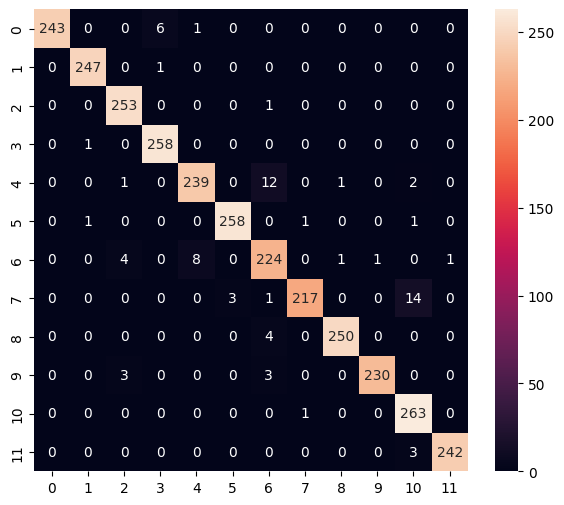

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       250
           1       0.99      1.00      0.99       248
           2       0.97      1.00      0.98       254
           3       0.97      1.00      0.98       259
           4       0.96      0.94      0.95       255
           5       0.99      0.99      0.99       261
           6       0.91      0.94      0.93       239
           7       0.99      0.92      0.96       235
           8       0.99      0.98      0.99       254
           9       1.00      0.97      0.99       236
          10       0.93      1.00      0.96       264
          11       1.00      0.99      0.99       245

    accuracy                           0.97      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       0.98      0.97      0.97      3000



In [20]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## Convert to model for Tensorflow-Lite

In [21]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmp25flds9l\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmp25flds9l\assets


40376

### Inference test

In [23]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [25]:
np.array([X_test[0]])

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.02218488,
         0.06465876, -0.0146348 ,  0.05926496,  0.11884475, -0.01701569,
         0.08632201,  0.16070312, -0.01962169,  0.10486561,  0.19020462,
        -0.01709484,  0.12106305,  0.08084619,  0.00436391,  0.1556533 ,
         0.09796482, -0.01446647,  0.11233675,  0.08692503, -0.02190341,
         0.09094197,  0.07435232, -0.02277351,  0.12977415,  0.04963142,
         0.00357175,  0.16036248,  0.0627234 , -0.01684708,  0.1055283 ,
         0.05262321, -0.02195145,  0.09149134,  0.04669213, -0.02119377,
         0.13078588,  0.01547199, -0.00126008,  0.16093946,  0.02913612,
        -0.02253325,  0.10988724,  0.02358136, -0.01267236,  0.09566867,
         0.01907289, -0.00104912,  0.12885457, -0.02165854, -0.00748157,
         0.15248716, -0.01079214, -0.01756132,  0.11804771, -0.00654224,
        -0.00589625,  0.10385078, -0.00800166,  0.00565961]],
      dtype=float32)

In [26]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.31254531e-13 1.00000000e+00 3.78083467e-11 1.34717121e-13
 1.25710294e-14 5.99576507e-16 8.17076171e-17 1.39158772e-13
 3.56757570e-20 1.12221405e-14 2.32914314e-16 5.92694827e-17]
1
CPU times: total: 0 ns
Wall time: 1 ms
